In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


# Create Datasets

In [3]:
# specify data location

train_dir = "src/data/train"
val_dir = "src/data/val"

In [4]:
# data transformation

train_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225],
    )
])

val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [5]:
# create datasets

train_data = datasets.ImageFolder(
    train_dir,
    transform = train_trans
)

val_data = datasets.ImageFolder(
    val_dir,
    transform = val_trans
)

In [6]:
# see labels

class_names = train_data.classes
class_names

['Ace',
 'Akainu',
 'Brook',
 'Chopper',
 'Crocodile',
 'Franky',
 'Jinbei',
 'Kurohige',
 'Law',
 'Luffy',
 'Mihawk',
 'Nami',
 'Rayleigh',
 'Robin',
 'Sanji',
 'Shanks',
 'Usopp',
 'Zoro']

In [7]:
# see label dict

class_dict = train_data.class_to_idx
class_dict

{'Ace': 0,
 'Akainu': 1,
 'Brook': 2,
 'Chopper': 3,
 'Crocodile': 4,
 'Franky': 5,
 'Jinbei': 6,
 'Kurohige': 7,
 'Law': 8,
 'Luffy': 9,
 'Mihawk': 10,
 'Nami': 11,
 'Rayleigh': 12,
 'Robin': 13,
 'Sanji': 14,
 'Shanks': 15,
 'Usopp': 16,
 'Zoro': 17}

In [8]:
train_loader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
    pin_memory = True
)

val_loader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle = False,
    pin_memory = True
)

# Create Model

In [9]:
model = models.mobilenet_v3_large(weights="DEFAULT")

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [11]:
# freeze model parameter
for param in model.parameters():
    param.requires_grad = False

In [12]:
# set seed for reproducibility
torch.manual_seed(42)

# change classifier head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=960, out_features=len(class_names))
)

# Create Engine

In [13]:
def train_step(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    loss_fn: nn.Module,
    optim: torch.optim.Optimizer
):
    # put model in train mode
    model.train()

    # var to track loss and acc
    train_loss, train_acc = 0, 0

    for batch_id, (X, y) in enumerate(loader):

        X, y = X.to(device), y.to(device)

        # forward pass
        logits = model(X)

        # calculate loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

        # track accuracy
        y_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (y_class == y).sum().item()/len(y_class)

    # average loss and acc
    train_loss = train_loss/len(loader)
    train_acc = train_acc/len(loader)

    return train_loss, train_acc        

In [14]:
def val_step(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    loss_fn: nn.Module,
):

    # var to track loss and acc
    val_loss, val_acc = 0, 0

    with torch.no_grad():
        
        # put model in eval mode
        model.eval()
        
        for batch_id, (X, y) in enumerate(loader):

            X, y = X.to(device), y.to(device)

            # forward pass
            logits = model(X)

            # calculate loss
            loss = loss_fn(logits, y)
            val_loss += loss.item()

            # calculate acc
            y_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            # y_class = logits.argmax(dim=1)
            val_acc += (y_class == y).sum().item()/len(y_class)
            

    # average loss
    val_loss = val_loss/len(loader)
    val_acc = val_acc/len(loader)

    return val_loss, val_acc

## Training

In [18]:
# hyperparams
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [20]:
results = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

prev_train_loss = np.Inf
prev_val_loss = np.Inf

for e in tqdm(range(epochs)):

    train_loss, train_acc = train_step(
        model=model,
        loader=train_loader,
        loss_fn=criterion,
        optim=optimizer,
        device=device
    )
    val_loss, val_acc = val_step(
        model=model,
        loader=val_loader,
        loss_fn=criterion,
        device=device
    )

    # Print out what's happening
    print(
        f"Epoch: {e+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

    # save model only decrease 
    if train_loss < prev_train_loss and val_loss < prev_val_loss:

        # save model
        torch.save(model.state_dict(), "src/checkpoint/checkpoint_notebook.pth")

        # update prev loss
        prev_train_loss = train_loss
        prev_val_loss = val_loss

        print("[INFO]: Model Saved")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8400 | train_acc: 0.4995 | val_loss: 1.3525 | val_acc: 0.6433
[INFO]: Model Saved
Epoch: 2 | train_loss: 1.5007 | train_acc: 0.5774 | val_loss: 1.1558 | val_acc: 0.6814
[INFO]: Model Saved
Epoch: 3 | train_loss: 1.3667 | train_acc: 0.5996 | val_loss: 1.0338 | val_acc: 0.7203
[INFO]: Model Saved
Epoch: 4 | train_loss: 1.3038 | train_acc: 0.6151 | val_loss: 0.9517 | val_acc: 0.7297
[INFO]: Model Saved
Epoch: 5 | train_loss: 1.2382 | train_acc: 0.6386 | val_loss: 0.9035 | val_acc: 0.7518
[INFO]: Model Saved
Epoch: 6 | train_loss: 1.2041 | train_acc: 0.6478 | val_loss: 0.8735 | val_acc: 0.7524
[INFO]: Model Saved
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.6438 | val_loss: 0.8319 | val_acc: 0.7595
[INFO]: Model Saved
Epoch: 8 | train_loss: 1.1504 | train_acc: 0.6569 | val_loss: 0.8318 | val_acc: 0.7569
[INFO]: Model Saved
Epoch: 9 | train_loss: 1.1528 | train_acc: 0.6616 | val_loss: 0.7958 | val_acc: 0.7687
Epoch: 10 | train_loss: 1.1196 | train_acc: 0.6627 | val_

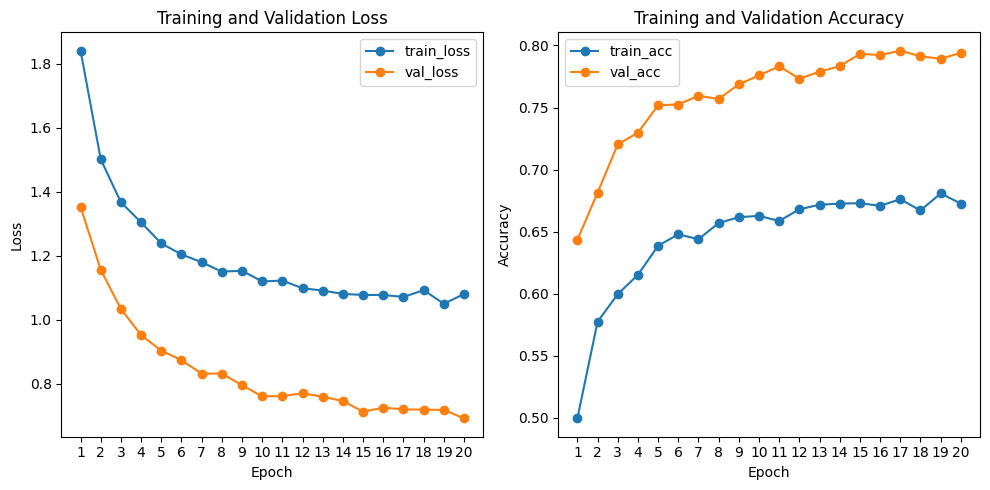

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(range(1, epochs+1), results["train_loss"], marker="o", label="train_loss")
plt.plot(range(1, epochs+1), results["val_loss"], marker="o", label="val_loss")
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(range(1, epochs+1), results["train_acc"], marker="o", label="train_acc")
plt.plot(range(1, epochs+1), results["val_acc"], marker="o", label="val_acc")
plt.xticks(range(1, epochs+1))
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Predictions

In [22]:
from PIL import Image

import os
from glob import glob
from pathlib import Path

In [23]:
def predict(
    model: nn.Module,
    model_path: str,
    image_path: str,
    device: torch.device
):
    # load model
    state_dict = torch.load(model_path)

    # add model parameters
    model.load_state_dict(state_dict)

    # put model to device
    model.to(device)

    # load image
    image = Image.open(image_path).convert("RGB")

    # transform and add batch
    img = val_trans(image).unsqueeze(0)

    # eval mode
    model.eval()

    # predict
    idx = torch.argmax(model(img.to(device)))

    # get class names
    names = class_names[idx]

    return names


In [24]:
model_dir = "src/checkpoint/checkpoint_notebook.pth"
test_dir = glob("src/data/test/*/*")

In [25]:
for f in test_dir:
    pred = predict(
        model=model, 
        model_path=model_dir, 
        image_path=Path(f),
        device=device
    )

    true_label = os.path.split(f)[0].split("\\")[-1]
    
    if true_label==pred:
        print(f"Image True Label: {true_label} | Image Pred Label: {pred}")
    else:
        print(f"Image True Label: {true_label} XXX Image Pred Label: {pred}")

Image True Label: Ace | Image Pred Label: Ace
Image True Label: Akainu | Image Pred Label: Akainu
Image True Label: Brook | Image Pred Label: Brook
Image True Label: Chopper | Image Pred Label: Chopper
Image True Label: Crocodile XXX Image Pred Label: Mihawk
Image True Label: Franky XXX Image Pred Label: Shanks
Image True Label: Jinbei | Image Pred Label: Jinbei
Image True Label: Kurohige XXX Image Pred Label: Rayleigh
Image True Label: Law | Image Pred Label: Law
Image True Label: Luffy | Image Pred Label: Luffy
Image True Label: Mihawk | Image Pred Label: Mihawk
Image True Label: Nami | Image Pred Label: Nami
Image True Label: Rayleigh | Image Pred Label: Rayleigh
Image True Label: Robin XXX Image Pred Label: Ace
Image True Label: Sanji | Image Pred Label: Sanji
Image True Label: Shanks | Image Pred Label: Shanks
Image True Label: Usopp | Image Pred Label: Usopp
Image True Label: Zoro | Image Pred Label: Zoro
